# Predictive Modeling w/ PyTorch
This notebook is a work-in-progress.

- Code to predict stock market movements with large scale technical indicator data used in PyTorch layers.
- Model choice will likely be LSTM but TBD.
- The original data is 'close' pricing and daily 'volume'. These are further extended with many technical indicators.
- The technical indicator data is then pulled for stocks that have close correlations in return with a 'given' input ticker.
- Data for several of these tickers (and their corrs) is then concatenated to construct training dataset.
- In-progress: Further fine-tuning of the initial train/test in PyTorch NN layers

REFERENCE:
- https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

In [1]:
import os
import os.path
from datetime import datetime
from typing import Any
import time
import numpy as np

import pandas as pd
from pandas.errors import EmptyDataError
from sqlalchemy import create_engine, text
from sklearn.preprocessing import MinMaxScaler

from functools import reduce
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
pd.options.mode.chained_assignment = None

In [2]:
BASE_DIR = '../../../../workspace/HelloPython/HistoricalMarketData/TechnicalIndicators'
TABLE_EQUITIES_DATA = 'equities_historic_data'
DURATIONS = (14, 30, 90, 200)  # Roughly for bi-weekly, monthly, quarterly, and 200 days running averages

In [3]:
try:
    DB = os.environ["DB"]
    DB_USER = os.environ["DB_USER"]
    DB_PWD = os.environ["DB_PWD"]
except KeyError:
    raise Exception("Required environment variables DB_USER and DB_PWD not set")
DB_URL = 'mysql+mysqlconnector://' + DB_USER + ':' + DB_PWD + '@localhost/' + DB
ENGINE = create_engine(DB_URL)

In [4]:
def generate_file_path(symbol, date=None):
    """
    Generates a file path for a given symbol
    to retrieve calculated tech indicator data
    from local CSV records
    :param symbol: ticker
    :param date: date embedded in the file name
    :return: file name and path
    """
    if date is not None:
        str_date = datetime.strftime(date, '%Y%m%d')
        file_name = symbol.lower() + '_' + str_date + '.csv'
    else:
        file_name = symbol.lower() + '.csv'
    file_path = os.path.join(BASE_DIR, file_name)
    if file_path is None:
        print('Could not find file for symbol:{}'.format(symbol))
    # print(file_path)
    return file_path, file_name

In [5]:
def retrieve_technical_indicator_data_for_symbol(symbol, columns = None, feature=None)\
        -> Any:
    """
    Retrieves Technical Indicator Data for a given symbol
    for given columns and labels them as Y (dependent) or
    X (input features).
    :param symbol: Symbol for which to retrieve Technical Indicator Data
    :param columns: Subset of Technical Indicator Data to retrieve
    :param feature: Y or X_i label where 'i' is feature number
    :return:
    """
    file_path, _ = generate_file_path(symbol)
    if file_path is not None:
        try:
            dfrm = pd.read_csv(file_path)
            dfrm['date'] = pd.to_datetime(dfrm['date'])
            dfrm.set_index('date', inplace=True)
            dfrm.sort_index(ascending=True)
            dfrm.index.name = 'date'
            if feature is None:
                feature = symbol.upper()
            if columns is not None:
                dfrm = dfrm[columns]
                dfrm.columns = [
                feature.upper()+'_'+column
                for column in dfrm.columns
                if column in columns
                ]
            else:
                dfrm.columns = [
                feature.upper()+'_'+column
                for column in dfrm.columns
                ]
            return dfrm
        except FileNotFoundError as e:
            print('Exception reading input data for symbol {}. Generating metadata starting from baseline date.'.format(symbol.upper()))
            return None
        except EmptyDataError as e:
            print(f'No technical indicators found for {symbol.upper()}. Generating metadata starting from baseline date.')
            print('Generating all records.')
            return None
    else:
        print(f"No technical indicators data in DB for '{symbol}'.")
    return None

tmp_df = retrieve_technical_indicator_data_for_symbol('AAPL', ['volume', 'close'])
tmp_df.tail(10)

,AAPL_volume,AAPL_close
date,,
2025-04-30,52286454,212.50
2025-05-01,57365675,213.32
2025-05-02,101010621,205.35
2025-05-05,69018452,198.89
2025-05-06,51216482,198.51
2025-05-07,68616943,196.25
2025-05-08,50478872,197.49
2025-05-09,36453923,198.53
2025-05-12,63775814,210.79


In [6]:
def find_symbols_w_highest_correlations(symbol, correlations, count):
    """
    Finds tickers whose return have highest correlation
    with the returns of given symbol
    :param symbol:
    :param correlations:
    :param count:
    :return:
    """
    if len(correlations[correlations['level_0'] == symbol.upper()+'_close']) <= 0:
        print("No correlations found for symbol:{}.".format(symbol.upper()))
        print("Likely data does not go far enough back.")
        return None
    corrs = correlations[correlations['level_0'] == symbol.upper()+'_close']
    corrs.sort_values(0, ascending = False, inplace = True)
    return_symbols = [symbol.replace('_close', '') for symbol in corrs.loc[:,'level_1'].tolist()]
    return return_symbols[0:count]

In [7]:
def gen_corrs(dfrm):
    """
    Generate correlations numbers for entire
    input dataframe consisting of daily close values
    :param dfrm:
    :return:
    """
    correlations = dfrm[dfrm.columns].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']]
    #print(correlations)`
    return correlations

## Training Dataset
Generate training dataset by finding symbols that have the highest correlation (based on daily 'close' values) with the given symbol. Then aggregate their returns over the years. The daily closing price of our target symbol becomes independent variable y and rest of the data including closing values of other symbols and their volumes make up the 'features' or 'X'.

In [8]:
MIN_ROW_COUNT = 5000 # Number of days to retrieve training data for
COMP_COUNT = 10 # Number of stocks to find high correlations with

query = 'SELECT symbol FROM equities_historic_data GROUP BY symbol HAVING COUNT(*) > '+str(MIN_ROW_COUNT)+''
with ENGINE.connect() as conn:
    res = conn.execute(text(query))
dfrm_symbols_list = pd.DataFrame(res.mappings().all())
symbols = dfrm_symbols_list['symbol'].tolist() # this is our universe of symbol tickers

# First calculate universal correlations among ALL these symbols
dfrm_list_daily_closes = list()
for symbol in symbols:
    dfrm = retrieve_technical_indicator_data_for_symbol(symbol, ['close', 'volume'])
    dfrm_list_daily_closes.append(dfrm)
merged_dfrm_daily_close_values = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_daily_closes)
correlations = gen_corrs(merged_dfrm_daily_close_values)

# Now merge a symbol's returns with returns of symbols
# it has the highest correlations with. Then stack (concat)
# all these returns across symbols to come up with our
# training dataset

# Data for a symbol and its corrs matches
# Think of this as a single line in a matrix
dfrm_list_single_row_data = list()
# Data for all symbol and their corrs matches
# Think of this as a matrix
dfrm_list_full_matrix_data = list() # Data for
tgt_symbols_list = ['JPM', 'C', 'MS', 'GS', 'WFC', 'BAC'] # Generate training data for this set only
for symbol in tgt_symbols_list:
    # Our dependent variable Y - generalize the name so we can stack up many symbols for training dataset
    dfrm_symbol = retrieve_technical_indicator_data_for_symbol(symbol, None, 'Y')
    dfrm_list_single_row_data.append(dfrm_symbol)
    symbols_w_highest_corrs = find_symbols_w_highest_correlations(symbol, correlations, COMP_COUNT)
    if symbols_w_highest_corrs is None:
        continue # Likely not enough data for a symbol. Continue with rest
    print(f'Symbols with highest correlations with {symbol.upper()} are {symbols_w_highest_corrs}')
    counter = 1
    for comp_symbol in symbols_w_highest_corrs:
        feature = 'X_'+str(counter)
        dfrm_tmp = retrieve_technical_indicator_data_for_symbol(comp_symbol, None, feature)
        dfrm_list_single_row_data.append(dfrm_tmp)
        counter += 1
    # Now merge the symbol and all its corrs data against the same date
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_single_row_data)
    dfrm_list_full_matrix_data.append(merged_df)
    dfrm_list_single_row_data.clear()
# Now concatenate data. This means dates are repeated
dfrm_aggr_training_data = pd.concat(dfrm_list_full_matrix_data)

Symbols with highest correlations with JPM are ['TXN', 'PNC', 'MAR', 'SPGI', 'SCHW', 'SIVB', 'SYK', 'WM', 'RJF', 'SNPS']
Symbols with highest correlations with C are ['AIG', 'RF', 'KEY', 'ZION', 'HIG', 'HBAN', 'ARNC', 'FITB', 'KIM', 'XRX']
Symbols with highest correlations with MS are ['HIG', 'DRE', 'ZION', 'KEY', 'FITB', 'LNC', 'MGM', 'RF', 'XRX', 'MET']
Symbols with highest correlations with GS are ['BK', 'STT', 'PRU', 'NTRS', 'CMA', 'CME', 'LNC', 'CBRE', 'SCHW', 'PFG']
Symbols with highest correlations with WFC are ['USB', 'DIS', 'PPG', 'UPS', 'SNA', 'IPG', 'OMC', 'MDLZ', 'AMGN', 'WHR']
No correlations found for symbol:BAC.
Likely data does not go far enough back.


In [9]:
dfrm_single_symbol_training_data = dfrm_list_full_matrix_data[3]
dfrm_single_symbol_training_data

,Y_symbol,Y_close,Y_volume,Y_mean_200,Y_stddev_200,Y_pcntleStdDevs_200,Y_pcntleVolume_200,Y_pcntleClosing_200,Y_oscillator_200,Y_accu_dist_200,...,X_10_stddev_90,X_10_accu_dist_200,X_10_bollingerLower_200,X_10_bollingerUpper_200,X_10_mean_200,X_10_oscillator_200,X_10_pcntleClosing_200,X_10_pcntleStdDevs_200,X_10_pcntleVolume_200,X_10_stddev_200
date,,,,,,,,,,,,,,,,,,,,,
2004-06-14,GS,91.53,3040000,99.808667,4.634889,28.148148,35.185185,2.222222,5.297297,-3.172852e+06,...,0.755276,140634.406918,32.358497,37.301058,34.829778,57.488987,43.703704,33.333333,44.444444,1.235640
2004-06-15,GS,90.21,5510000,99.738088,4.690472,28.676471,93.382353,0.735294,0.000000,-3.563257e+06,...,0.755282,185644.678025,32.368949,37.293698,34.831324,59.911894,51.470588,33.088235,21.323529,1.231187
2004-06-16,GS,89.98,4150000,99.693235,4.754441,30.147059,77.941176,0.735294,0.000000,-3.586125e+06,...,0.755282,272795.581757,32.401718,37.292400,34.847059,64.537445,59.191176,32.352941,16.176471,1.222670
2004-06-17,GS,89.34,3500000,99.617664,4.818807,34.306569,55.474453,0.729927,0.000000,-3.585496e+06,...,0.751884,231133.476961,32.412386,37.286154,34.849270,62.334802,56.204380,32.116788,36.496350,1.218442
2004-06-18,GS,89.18,3820000,99.542029,4.882711,39.130435,64.492754,0.724638,0.000000,-3.587196e+06,...,0.752121,230812.922173,32.422936,37.279963,34.851449,62.334802,56.159420,31.884058,36.956522,1.214257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-07,GS,551.92,1955077,575.719118,46.213743,NaN,76.470588,32.352941,42.720389,-2.087827e+05,...,5.751076,-317003.241874,71.909203,91.322121,81.615662,39.243615,23.529412,NaN,74.264706,4.853230
2025-05-08,GS,565.70,1994630,575.645985,46.051482,NaN,76.642336,40.875912,49.283231,-2.061593e+04,...,5.755323,-130175.051124,71.913071,91.277732,81.595401,45.579568,31.021898,NaN,51.094891,4.841165
2025-05-09,GS,567.10,1522728,575.584058,45.888870,NaN,65.217391,42.753623,49.949993,-1.438934e+03,...,5.756040,-121174.210643,71.918032,91.233707,81.575870,45.874263,31.884058,NaN,19.565217,4.828919


## Data Normalization and Train-Test split

In [10]:
# Start with separating independent vector matrix (X) and dependent vector (y)
# Take care of X first
batch_size = 5
len_data = len(dfrm_single_symbol_training_data)
tgt_field_column_name = 'Y_close'
tgt_symbol_column_name = 'Y_symbol'
train_to_total_ratio = 0.8
test_to_total_ratio = 1- train_to_total_ratio

# The train and test dataset must be perfect multiple of batch size
# Try to find some API to simplify this.
offset_test_data_start = len_data - int(test_to_total_ratio * len_data)
offset_test_data_start = offset_test_data_start - (offset_test_data_start % batch_size)
offset_test_date_end = offset_test_data_start + int(test_to_total_ratio * len_data)
offset_test_date_end = offset_test_date_end - (offset_test_date_end % batch_size)

dfrm_training = dfrm_single_symbol_training_data.iloc[batch_size:offset_test_data_start, :]
dfrm_test = dfrm_single_symbol_training_data.iloc[offset_test_data_start:offset_test_date_end, :]
print(len(dfrm_training))
print(len(dfrm_test))

4185
1045


In [11]:
# x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'symbol' not in column]
x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'close' in column]
Y_train = dfrm_training[tgt_field_column_name]
X_train = dfrm_training[x_columns]
# null_indices = X_train[X_train.isnull().any(axis=1)].index
# X_train = X_train.drop(null_indices)
# Y_train = Y_train.drop(null_indices)

Y_test = dfrm_test[tgt_field_column_name]
X_test = dfrm_test[x_columns]

# Scale the target variable
scaler_y = MinMaxScaler(feature_range=(-1, 1))
transformed_Y_train = scaler_y.fit_transform(Y_train.values.reshape(-1,1))
transformed_Y_test = scaler_y.transform(Y_test.values.reshape(-1,1))

# Scale the features
scaler_x = MinMaxScaler(feature_range=(-1, 1))
transformed_X_train = scaler_x.fit_transform(X_train)
transformed_X_test = scaler_x.transform(X_test)

In [12]:
X_train

,X_1_close,X_2_close,X_3_close,X_4_close,X_5_close,X_6_close,X_7_close,X_8_close,X_9_close,X_10_close
date,,,,,,,,,,
2004-06-21,30.464,49.08,45.35,40.89,36.427,26.004,45.67,6.363,9.22,34.89
2004-06-22,31.206,49.39,45.74,41.32,36.473,25.800,45.65,6.353,9.45,34.52
2004-06-23,31.143,49.78,45.98,41.82,36.727,26.710,45.60,6.297,9.49,34.74
2004-06-24,31.143,50.01,46.09,42.21,36.667,27.002,45.74,6.333,9.99,34.52
2004-06-25,31.185,49.60,45.66,42.59,36.447,27.680,45.62,6.333,9.80,34.56
...,...,...,...,...,...,...,...,...,...,...
2021-03-03,44.530,79.31,89.37,98.55,69.880,205.795,58.57,77.910,64.96,57.91
2021-03-04,44.760,78.20,88.57,97.57,68.370,207.020,56.74,76.630,64.77,56.67
2021-03-05,45.030,79.42,90.66,99.92,69.880,213.920,58.57,77.280,65.02,58.68


In [13]:
x_train = torch.from_numpy(transformed_X_train).to(torch.float32)
x_test = torch.from_numpy(transformed_X_test).to(torch.float32)
y_train = torch.from_numpy(transformed_Y_train).to(torch.float32)
y_test = torch.from_numpy(transformed_Y_test).to(torch.float32)

# Create a dataset and data loader
train_dataset = TensorDataset(x_train.unsqueeze(1), y_train)  # Add sequence dimension
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)

test_dataset = TensorDataset(x_test.unsqueeze(1), y_test)  # Add sequence dimension
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

In [14]:
x_train.shape

torch.Size([4185, 10])

In [15]:
# Dimensions for data input
input_dim = len(X_train.columns) # Number of features
#hidden_dim = int(len(X_train)) # Number of samples or units
hidden_dim = 512
num_layers = 2
output_dim = 1
num_epochs = 20 # Intentionally keeping low for initial debugging
seq_len = 10

## Model Definition and Predictions

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.1)

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure x has batch dimension
        #print("Input size:", x.size(0))
        # print(f'X:{x}')
        x = self.dropout(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [17]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers= num_layers, output_dim=output_dim, )
criterion = torch.nn.MSELoss(reduction='sum')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
model.lstm

LSTM(10, 512, num_layers=2, batch_first=True)

## Model Training and Evaluation

In [18]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    counter = 1
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.reshape(-1, 1, input_dim)
        y_train_pred = model(x_batch)
        loss = criterion(y_train_pred, y_batch)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        print(f'Epoch:{t:}, Batch:{counter}, Loss: {loss.item():.4f}')
        counter += 1
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch:0, Batch:1, Loss: 2.7414
Epoch:0, Batch:2, Loss: 0.8431
Epoch:0, Batch:3, Loss: 1.5422
Epoch:0, Batch:4, Loss: 0.0225
Epoch:0, Batch:5, Loss: 0.3906
Epoch:0, Batch:6, Loss: 0.6027
Epoch:0, Batch:7, Loss: 0.4733
Epoch:0, Batch:8, Loss: 0.2035
Epoch:0, Batch:9, Loss: 0.0188
Epoch:0, Batch:10, Loss: 0.2294
Epoch:0, Batch:11, Loss: 0.1808
Epoch:0, Batch:12, Loss: 0.0965
Epoch:0, Batch:13, Loss: 0.0075
Epoch:0, Batch:14, Loss: 0.0684
Epoch:0, Batch:15, Loss: 0.1538
Epoch:0, Batch:16, Loss: 0.1383
Epoch:0, Batch:17, Loss: 0.0895
Epoch:0, Batch:18, Loss: 0.0170
Epoch:0, Batch:19, Loss: 0.0068
Epoch:0, Batch:20, Loss: 0.0365
Epoch:0, Batch:21, Loss: 0.0881
Epoch:0, Batch:22, Loss: 0.0717
Epoch:0, Batch:23, Loss: 0.0476
Epoch:0, Batch:24, Loss: 0.0091
Epoch:0, Batch:25, Loss: 0.0017
Epoch:0, Batch:26, Loss: 0.0440
Epoch:0, Batch:27, Loss: 0.0612
Epoch:0, Batch:28, Loss: 0.0575
Epoch:0, Batch:29, Loss: 0.0571
Epoch:0, Batch:30, Loss: 0.0259
Epoch:0, Batch:31, Loss: 0.0031
Epoch:0, Batch:32

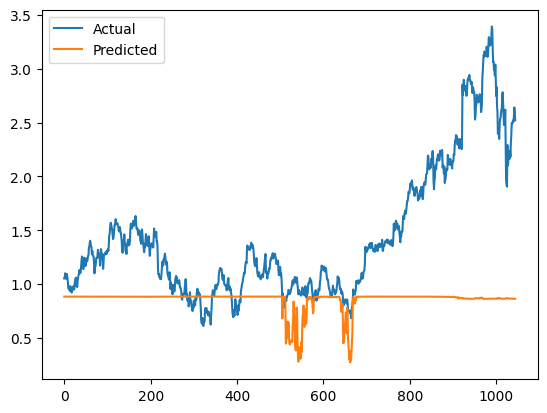

In [21]:
# Make predictions on the test dataset
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        test_labels.extend(labels.cpu().numpy().flatten()) # Add observed values to list
        inputs = inputs.reshape(-1, 1, input_dim)
        outputs = model(inputs)
        test_preds.extend(outputs.cpu().numpy().flatten()) # Add predicted values to list

# Plot predictions against actual values
plt.plot(test_labels, label='Actual')
plt.plot(test_preds, label='Predicted')
plt.legend()
plt.show()
